In [1]:
import seaborn as sns
from main import preprocess

In [2]:
df, df_small, source = preprocess(0, 6)

In [3]:
df.iloc[0]

age               0.301370
workclass         0.625000
education-num     0.800000
capital-gain      0.021740
capital-loss      0.000000
hours-per-week    0.397959
50K               0.000000
Name: 0, dtype: float64

In [4]:
df_small.iloc[source]

age               0.333924
workclass         0.513062
education-num     0.675521
capital-gain      0.009708
capital-loss      0.008112
hours-per-week    0.416643
50K               0.000000
Name: 4, dtype: float64

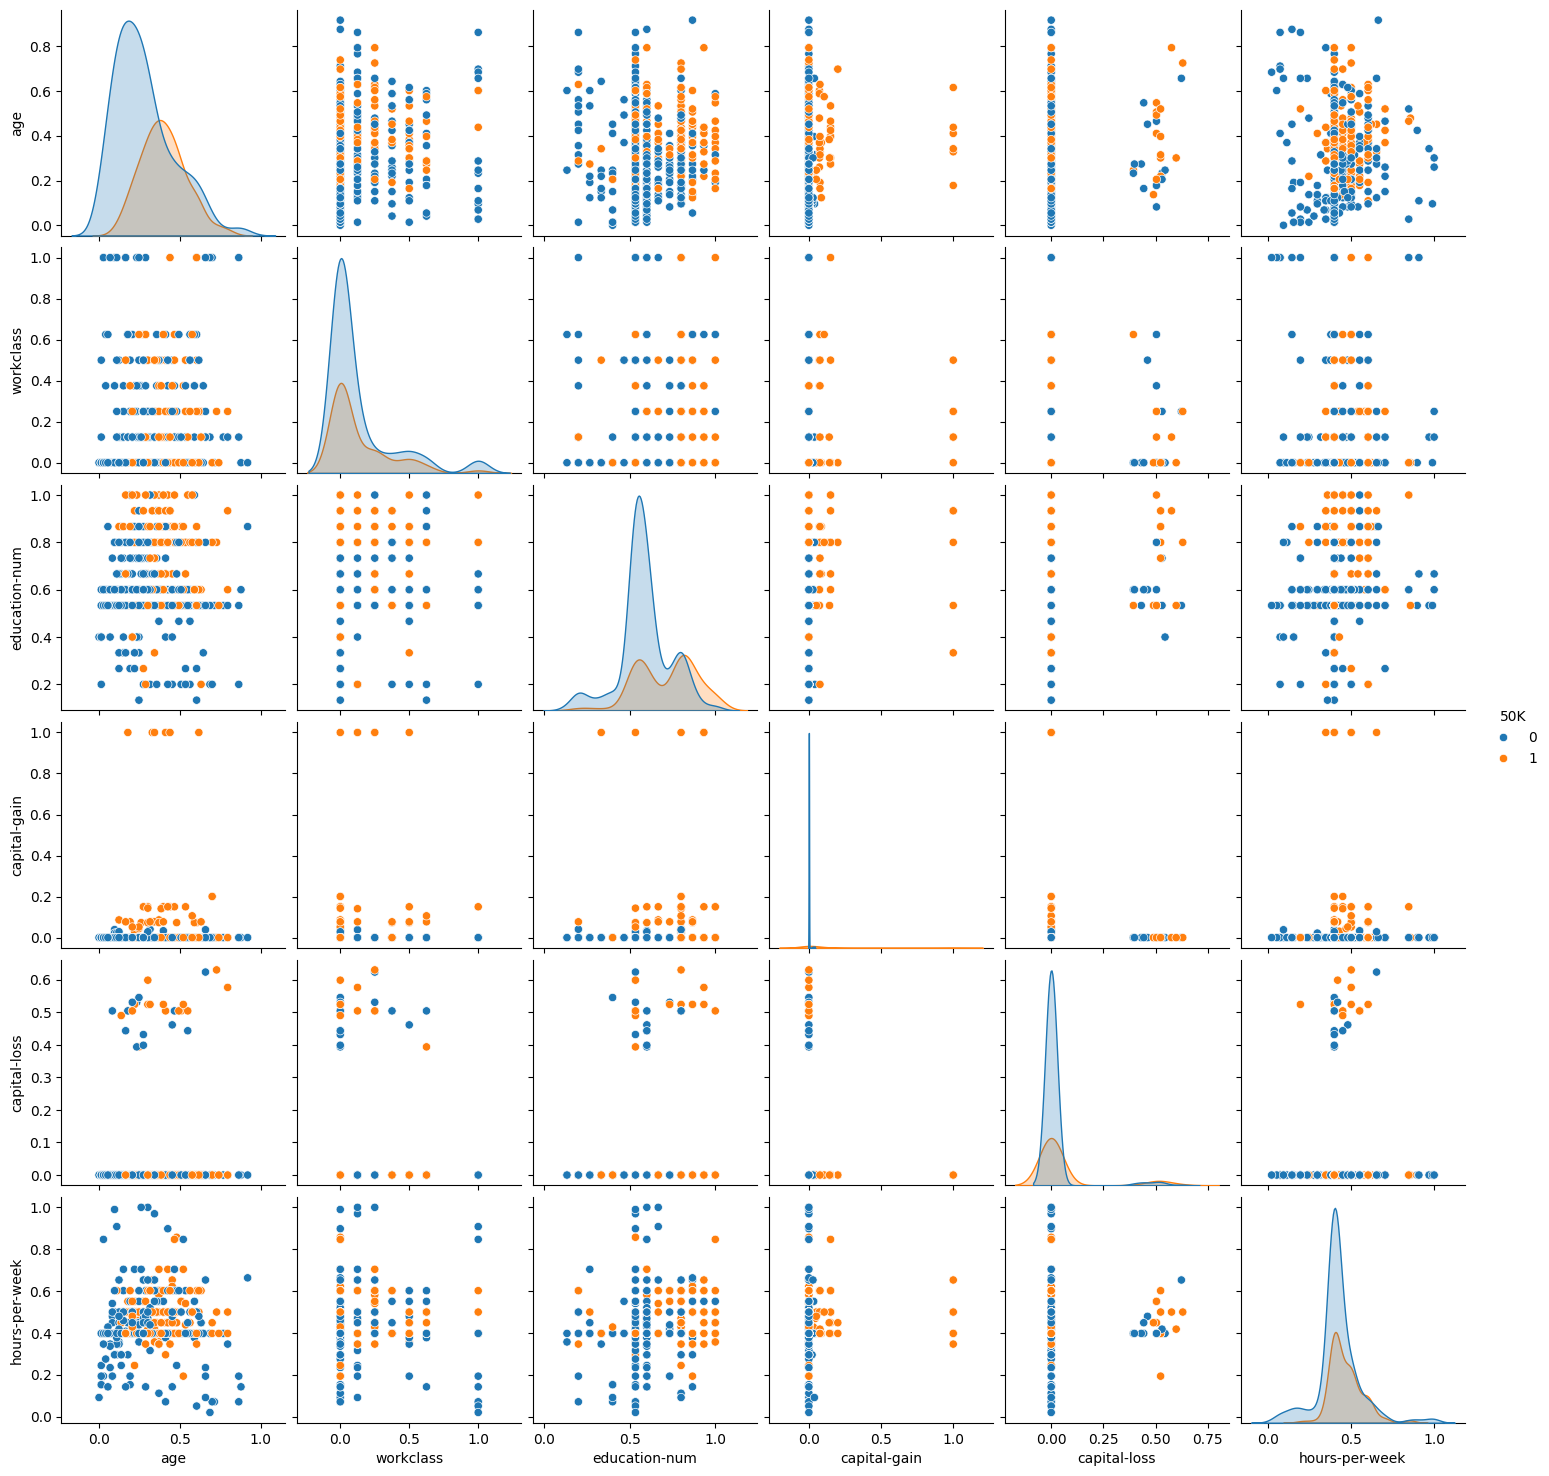

In [5]:
sns.pairplot(df.sample(512), hue="50K")

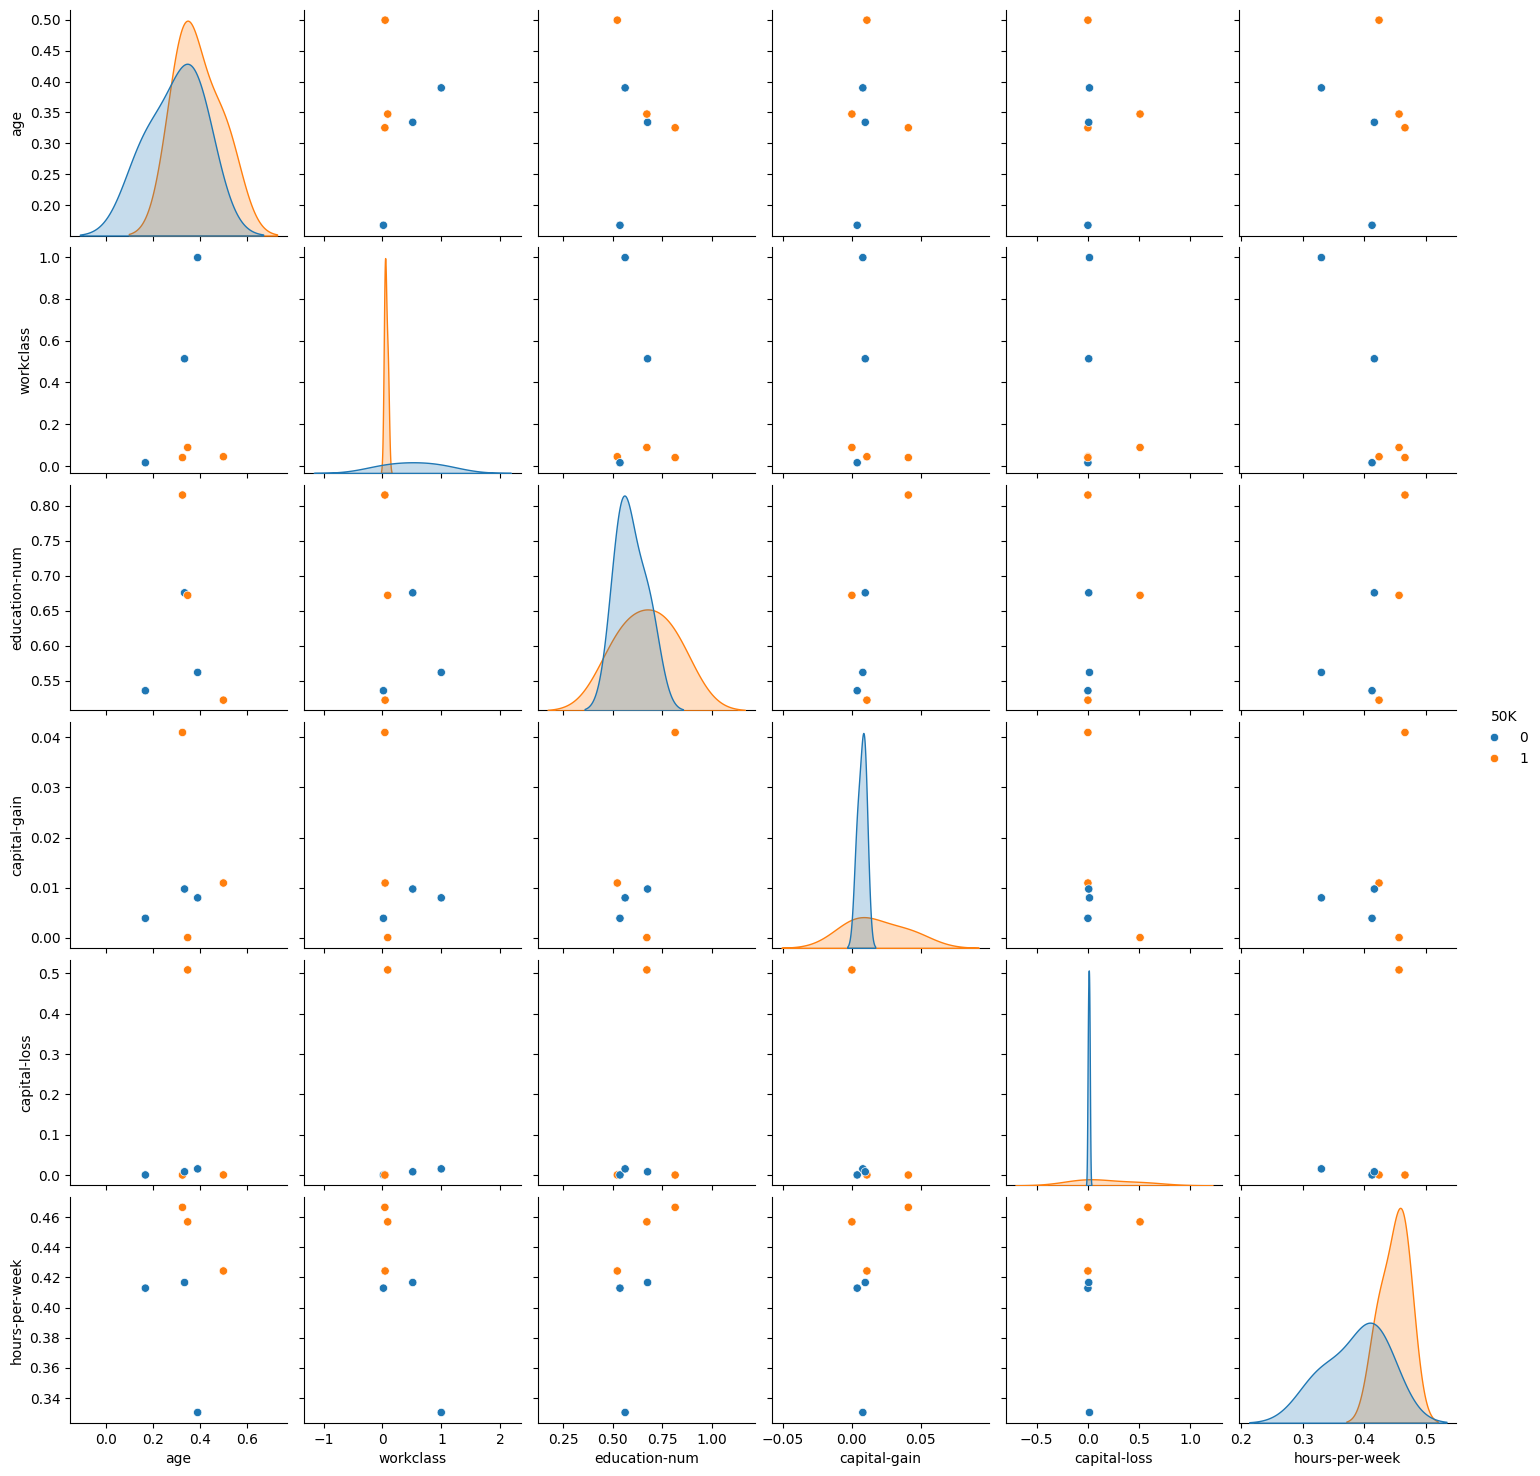

In [6]:
sns.pairplot(df_small, hue="50K")

In [7]:
df.describe()

,age,workclass,education-num,capital-gain,capital-loss,hours-per-week,50K
count,17653.000000,17653.000000,17653.000000,17653.000000,17653.000000,17653.000000,17653.000000
mean,0.312178,0.133901,0.617666,0.014086,0.027814,0.425856,0.325157
std,0.184411,0.256048,0.165146,0.086013,0.116493,0.125438,0.468447
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.164384,0.000000,0.533333,0.000000,0.000000,0.397959,0.000000
50%,0.287671,0.000000,0.600000,0.000000,0.000000,0.397959,0.000000
75%,0.438356,0.125000,0.800000,0.000000,0.000000,0.500000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
df_small.describe()

,age,workclass,education-num,capital-gain,capital-loss,hours-per-week,50K
count,6.000000,6.000000,6.000000,6.000000e+00,6.000000,6.000000,6.000000
mean,0.343768,0.283212,0.630453,1.223497e-02,0.088799,0.417944,0.500000
std,0.107765,0.396800,0.112333,1.465338e-02,0.205806,0.048177,0.547723
min,0.167025,0.015838,0.522422,-9.887924e-17,0.000045,0.330414,0.000000
25%,0.327303,0.041402,0.542427,4.875656e-03,0.000281,0.413840,0.000000
50%,0.340610,0.066631,0.616951,8.826964e-03,0.004218,0.420471,0.500000
75%,0.379139,0.406969,0.674619,1.060893e-02,0.013526,0.448740,1.000000
max,0.499512,0.996767,0.814968,4.099440e-02,0.508714,0.466517,1.000000


In [11]:
from algo import *


In [10]:
recourse(df_small, source, limit=100000)

[[(0.1655877366101115, 0.2538196828586726)],
 [(0.0, 0.23470212650672204)],
 [(0.4837057179418086, 0.8473701896446251)],
 [(0.13944729172124548, 0.2807686489878903)],
 [(0.0, 0.0)],
 [(0.013371028018976105, -0.2486382801088875)]]

In [13]:
adj = make_knn_adj(df_small, 5)
graph = adj_to_graph(adj)
set_cost(graph, df_small)
dists = multicost_shortest_path(graph, source, limit=1000)
dists


[[(0.1655877366101115, 0.2538196828586726)],
 [(0.0, 0.23470212650672204)],
 [(0.4837057179418086, 0.8473701896446251)],
 [(0.13944729172124548, 0.2807686489878903)],
 [(0.0, 0.0)],
 [(0.013371028018976105, -0.2486382801088875)]]

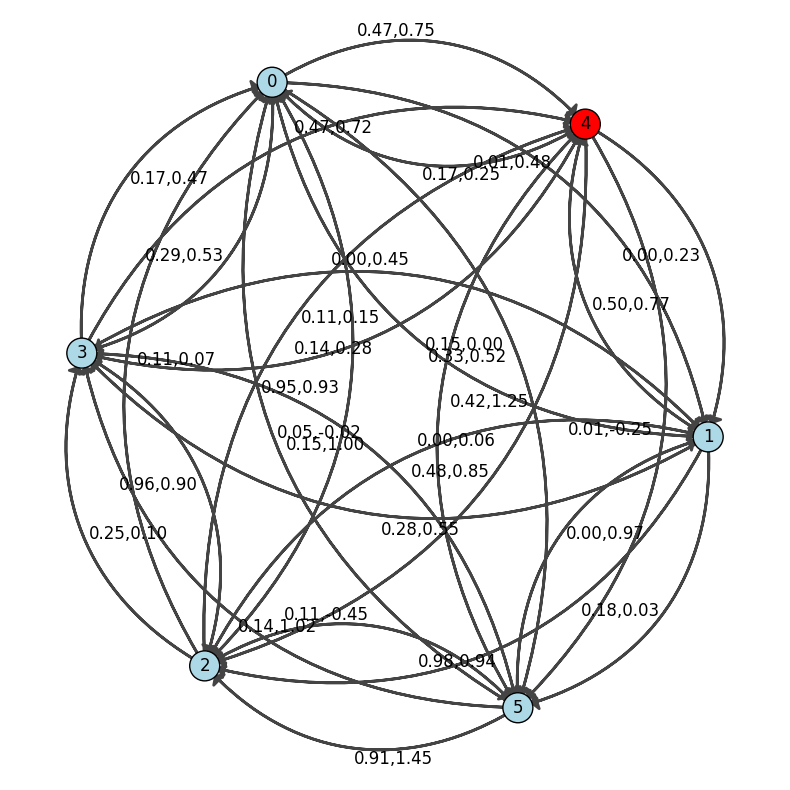

In [35]:
import igraph as ig
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8), layout="tight")
ig.plot(
    graph,
    ax,
    edge_arrow_size=5,
    vertex_label=graph.vs.indices,
    vertex_color=["red" if i == source else "lightblue" for i in range(graph.vcount())],
    edge_label=[f"{a:.2f},{b:.2f}" for a, b in graph.es["cost"]],
)
plt.show()


In [20]:
help(ig.plot)

Help on function plot in module igraph.drawing:

plot(obj, target=None, bbox=(0, 0, 600, 600), *args, **kwds)
    Plots the given object to the given target.

    Positional and keyword arguments not explicitly mentioned here will be
    passed down to the C{__plot__} method of the object being plotted.
    Since you are most likely interested in the keyword arguments available
    for graph plots, see L{Graph.__plot__} as well.

    @param obj: the object to be plotted
    @param target: the target where the object should be plotted. It can be one
      of the following types:

        - C{matplotib.axes.Axes} -- a matplotlib/pyplot axes in which the
          graph will be plotted. Drawing is delegated to the chosen matplotlib
          backend, and you can use interactive backends and matplotlib
          functions to save to file as well.

        - C{string} -- a file with the given name will be created and the plot
          will be stored there. If you are using the Cairo backen